In [751]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
from sklearn import preprocessing as pp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [752]:
# Features are mainly demographic data from onset of survey,
# excluding 1 relationship centric feature - 'relationship quality'

# Goal is to only use data gathered at the start of the survey, Wave 1,
# to try to predict the outcome of partnered respondents, based on respondent and partner demographic data
# This allows us to investigate and discover what type of individuals 
# have better chance of surviving a 6 year relationship

# EDA & Cleaning

In [753]:
df_w5 = pd.read_stata('./datasets/HCMST_wave_5_supplement_ver_1.dta')
df_w4 = pd.read_stata('./datasets/wave_4_supplement_v1_2.dta')
df_w123 = pd.read_stata('./datasets/HCMST_ver_3.04.dta')

In [754]:
w5_cols = df_w5.columns.tolist()
w4_cols = df_w4.columns.tolist()
w123_cols = df_w123.columns.tolist()

In [755]:
# Checking number of features for each wave
print(len(w5_cols), len(w4_cols), len(w123_cols))

78 62 387


In [756]:
# checking rows and columns for each wave
print(df_w123.shape, df_w4.shape, df_w5.shape)

(4002, 387) (4002, 62) (4002, 78)


In [757]:
# 
wave_1_couples = df_w123.loc[(df_w123['qflag'] == 'partnered') & (df_w123['partner_deceased'] == 'not deceased'), 'caseid_new':]

In [758]:
wave_1_couples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2981 entries, 0 to 4001
Columns: 387 entries, caseid_new to w3_nonmbtiming_month
dtypes: category(325), float32(16), float64(39), int32(4), int8(2), object(1)
memory usage: 2.1+ MB


In [759]:
# Get relationship status of couples that have deceased partners
w2_dead = wave_1_couples[wave_1_couples.w2_broke_up == 'partner passed away'].index
w3_dead = wave_1_couples[wave_1_couples.w3_broke_up == 'partner deceased'].index
w4_dead = df_w4[df_w4.w4_broke_up == 'partner passed away'].index
w5_dead = df_w5[df_w5.w5_broke_up == 'partner deceased'].index

print(len(wave_1_couples.loc[wave_1_couples.loc[w2_dead,['qflag']].index][wave_1_couples.qflag == 'partnered'].index))
print('')
print(len(wave_1_couples.loc[wave_1_couples.loc[w3_dead,['w2_broke_up']].index][wave_1_couples.w2_broke_up == 'still together'].index))
print('') 
print(len(wave_1_couples.loc[wave_1_couples.loc[w4_dead,['w3_broke_up']].index][wave_1_couples.w3_broke_up == 'still together'].index))
print('') 
print(len(df_w4.loc[df_w4.loc[w5_dead,['w4_broke_up']].index][df_w4.w4_broke_up == 'still together'].index))

40

18

12

8


/Users/david.yan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/david.yan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Users/david.yan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/david.yan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


In [760]:
w2_dead_st = wave_1_couples.loc[wave_1_couples.loc[w2_dead,['qflag','caseid_new']].index][wave_1_couples.qflag == 'partnered'].caseid_new.values
w3_dead_st = wave_1_couples.loc[wave_1_couples.loc[w3_dead,['w2_broke_up','caseid_new']].index][wave_1_couples.w2_broke_up == 'still together'].caseid_new.values
w4_dead_st = wave_1_couples.loc[wave_1_couples.loc[w4_dead,['w3_broke_up','caseid_new']].index][wave_1_couples.w3_broke_up == 'still together'].caseid_new.values
w5_dead_st = df_w4.loc[df_w4.loc[w5_dead,['w4_broke_up','caseid_new']].index][df_w4.w4_broke_up == 'still together'].caseid_new.values

/Users/david.yan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/david.yan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/david.yan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/david.yan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [761]:
# prior relationship status of all couples that have deceased partners is still together
tot_dead_list = np.concatenate((w2_dead_st,w3_dead_st,w4_dead_st,w5_dead_st))

In [762]:
wave_2_couples_broke_up = wave_1_couples.loc[wave_1_couples['w2_broke_up']=='broke up']
wave_3_couples_broke_up = wave_1_couples.loc[wave_1_couples['w3_broke_up']=='broke up']
w4_breakup = df_w4.loc[df_w4['w4_broke_up']=='broke up']
w5_breakup = df_w5.loc[df_w5['w5_broke_up']=='broke up']
survived_couples=df_w5.loc[df_w5['w5_broke_up']=='still together']

In [763]:
w2_breakup_list=wave_2_couples_broke_up['caseid_new'].tolist()
w3_breakup_list=wave_3_couples_broke_up['caseid_new'].tolist()
w4_breakup_list=w4_breakup['caseid_new'].tolist()
w5_breakup_list=w5_breakup['caseid_new'].tolist()
survived_couples_list=survived_couples['caseid_new'].tolist()

In [764]:
# Must make sure all couples in dataset are partnered right from the start
cp_index = np.concatenate((w4_breakup.index,w5_breakup.index,survived_couples.index))
wave_1_couples.loc[cp_index].head()

,caseid_new,weight1,weight2,ppage,ppagecat,ppagect4,ppeduc,ppeducat,ppethm,ppgender,...,w3_mbtiming_year,w3_mbtiming_month,w3_q5,w3_q6,w3_q7,w3_q8,w3_q9,w3_q10,w3_nonmbtiming_year,w3_nonmbtiming_month
22,44486,3581,3581.0,48,45-54,45-59,"some college, no degree",some college,"black, non-hispanic",female,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,97195,43431,43431.0,19,18-24,18-29,"some college, no degree",some college,"white, non-hispanic",male,...,NaN,NaN,yes,no,"no, did not marry [xNameP]",NaN,NaN,NaN,NaN,NaN
97,121515,39909,39909.0,51,45-54,45-59,bachelors degree,bachelor's degree or higher,"white, non-hispanic",female,...,NaN,NaN,yes,no,"no, did not marry [xNameP]",NaN,NaN,NaN,NaN,NaN
119,144545,109536,109536.0,54,45-54,45-59,professional or doctorate degree,bachelor's degree or higher,"other, non-hispanic",male,...,NaN,NaN,yes,no,"no, did not marry [xNameP]",NaN,NaN,NaN,NaN,NaN
122,147245,69278,69278.0,24,18-24,18-29,high school graduate - high school diploma or ...,high school,"white, non-hispanic",male,...,NaN,NaN,yes,yes,"no, did not marry [xNameP]",NaN,NaN,NaN,NaN,NaN


In [765]:
# for x in tot_dead_st:
#     if x in w2_breakup_list or x in w3_breakup_list or x in w4_breakup_list or x in w5_breakup_list:
#         print(x)

In [766]:
# check the imbalance of the data
print(len(w5_breakup_list)+len(w4_breakup_list)+len(w3_breakup_list)+len(w2_breakup_list))
print(len(tot_dead_list)+len(survived_couples_list))

503
1144


In [767]:
breakup_list = np.concatenate((w5_breakup_list,w4_breakup_list,w3_breakup_list,w2_breakup_list), axis=0)
together_list = np.concatenate((tot_dead_list,survived_couples_list), axis=0)

In [768]:
# only want wave 1 features
features = wave_1_couples.loc[:,:'coresident'].columns
couple_data = wave_1_couples[features]

In [769]:
couple_data.set_index(keys=['caseid_new'], inplace=True)

In [770]:
# dropping obviously irrelevant columns
cols_to_drop = couple_data.loc[w2_breakup_list,'pphhcomp11_member2_age':'weight_couples_coresident'].columns

In [771]:
couple_data.drop(labels=cols_to_drop, axis=1, inplace=True)

/Users/david.yan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [772]:
couple_breakup = couple_data.loc[breakup_list,:]
couple_together = couple_data.loc[together_list,:]

In [773]:
print(couple_breakup.shape)
print(couple_together.shape)

(503, 231)
(1144, 231)


In [774]:
couple_breakup['relationship_outcome_6yrs'] = [1 for x in range(couple_breakup.shape[0])]
couple_together['relationship_outcome_6yrs'] = [0 for x in range(couple_together.shape[0])]

In [775]:
print(couple_breakup.relationship_outcome_6yrs.unique())
print(couple_together.relationship_outcome_6yrs.unique())

[1]
[0]


In [776]:
couple_data = pd.concat([couple_breakup, couple_together], axis=0)

In [777]:
# drop more unnecessary columns that will not be useful features
couple_data.drop(labels=['weight1','weight2'], axis=1, inplace=True)
# drop age category columns, already have age continuous column
couple_data.drop(labels=['ppagecat','ppagect4'], axis=1, inplace=True)
# use education category instead of education
couple_data.drop(labels=['ppeduc'], axis=1, inplace=True)
# use continuous household income instead of categorical household income
couple_data.drop(labels=['ppincimp'], axis=1, inplace=True)
# Drop MSA metropolitan statistical area, irrelevancy
couple_data.drop(labels=['ppmsacat'], axis=1, inplace=True)
# drop ppt01, ppt1317, ppt25, ppt612, features aggregated in children_in_hh
couple_data.drop(labels=['ppt01','ppt1317','ppt25','ppt612'], axis=1, inplace=True)
# drop ppq14arace, redundant column, there are individual race columns
couple_data.drop(labels=['ppq14arace'], axis=1, inplace=True)
# drop ppppcmdate_yrmo, pppadate_yrmo, date of survey is irrelevant
couple_data.drop(labels=['ppppcmdate_yrmo','pppadate_yrmo'], axis=1, inplace=True)
# drop HCMST_main_interview_yrmo, date of interview is irrelevant
# drop interview duration, qflag - all partnered
couple_data.drop(labels=['HCMST_main_interview_yrmo','duration','qflag'], axis=1, inplace=True)
# drop papglb_status, same as glbstatus
# drop recsource, source of recruitment is irrelevant
# drop s1a,s2,q3_codes,q5,q15a1_compressed,q17c,q17d redundant or too many NAs, 
couple_data.drop(labels=['glbstatus','papglb_status','recsource','s1','s1a','s2','q3_codes','q5','q15a1_compressed','q17c','q17d'], axis=1, inplace=True)
# drop q18a_1, q18a_2, q18a_3, q18b_codes, q18c_codes, low variance and too many NAs
couple_data.drop(labels=['q18a_1','q18a_2','q18a_3','q18b_codes','q18c_codes','q18a_refused'], axis=1, inplace=True)
# drop q20, q21a_refusal, q21b_refusal,q21c_refusal,q21d_refusal,q21e,q21e_refusal,q24_codes
# 'q31_9','q31_other_text_entered','q33_7','q33_other_text_entered',not usable column
# q35_codes, q35_text_entered, summary_q24_total
couple_data.drop(labels=['q20','q21a_refusal','q21b_refusal','q21c_refusal','q21d_refusal',
                        'q21e','q21e_refusal','q24_codes','q31_9','q31_other_text_entered',
                        'q33_7','q33_other_text_entered','q35_codes','q35_text_entered',
                        'summary_q24_total'], axis=1, inplace=True)
# drop marrynotreally, marrycountry, civilnotreally, partner_deceased
# partner_religion_reclassified, partner_religion_child_reclass, own_religion_child_reclass
# q32_internet, how_met_online, potential_partner_gender_recodes, how_long_ago_first_met_cat
# duplicated representation of previous columns, too many NA
couple_data.drop(labels=['marrynotreally','marrycountry','civilnotreally','partner_deceased',
                        'partner_religion_reclassified','partner_religion_child_reclass',
                        'own_religion_child_reclass','q32_internet','how_met_online',
                        'either_internet','either_internet_adjusted','potential_partner_gender_recodes',
                        'how_long_ago_first_met_cat','pphouseholdsize'], axis=1, inplace=True)
# drop q24_R_friend, q24_P_friend, q24_R_family, q24_P_family, q24_R_neighbor, q24_P_neighbor
# q24_R_cowork, q24_P_cowork,papreligion,q13b,respondent_religion_at_16,partner_religion_at_16
# q7b, q8b,q30
# columns are aggregated into other columns
couple_data.drop(labels=['q24_R_friend','q24_P_friend','q24_R_family','q24_P_family','q24_R_neighbor','q24_P_neighbor',
                        'q24_R_cowork','q24_P_cowork','papreligion','q13b','respondent_religion_at_16',
                        'partner_religion_at_16','q7b','q8b','q30'], axis=1, inplace=True)
# drop home_country_recode, too many NAs
couple_data.drop(labels=['home_country_recode'], axis=1, inplace=True)
# remove q34, same as relationship quality
couple_data.drop(labels=['q34'], axis=1, inplace=True)

In [778]:
# Iterate through each series in the dataframe, impute nulls with highest mode, binary values
import random
sr = random.SystemRandom()

def impute_bin_cols(cols):
    
    for col in cols:
        # get number of keys
        key_arr = [k for k in couple_data[col].value_counts().sort_values(ascending=False).to_dict().keys()]
        greater_key = key_arr[0]
        greater_counts = couple_data[col].value_counts().to_dict()[greater_key]

        if len(couple_data[col].value_counts().sort_values(ascending=False).to_dict().keys()) > 1:
            lesser_key = key_arr[1]
            lesser_counts = couple_data[col].value_counts().to_dict()[lesser_key]

            if greater_counts > lesser_counts:
                couple_data[col].fillna(greater_key, inplace=True)
            else:
                couple_data[col].fillna(sr.choice([greater_key,lesser_key]), inplace=True)
        else:
            couple_data[col].fillna(greater_key, inplace=True)
    
    return couple_data[cols].isnull().sum()

In [779]:
couple_data.isnull().sum().sort_values(ascending=False)

q22                                 1266
q17b                                 955
q26                                  730
q21d                                 698
q17a                                 692
parental_approval                    451
q21c                                 344
how_long_ago_first_cohab             344
q24_internet_game                     33
q24_internet_chat                     33
q24_vol_org                           33
q24_customer                          33
q24_bar_restaurant                    33
q24_internet_dating                   33
q24_internet_social_networking        33
q24_private_party                     33
q24_internet_community                33
q24_internet_other                    33
q24_public                            33
q24_military                          33
q24_blind_date                        33
q24_vacation                          33
q24_singles_service_non_internet      33
q24_church                            33
q24_btwn_I_sig_o

In [780]:
# investigate null features
# drop features with more than 70% null
couple_data.drop(labels=['q22'], axis=1, inplace=True)
# drop q17a, use q17b instead, current marriage already taken into account in 'married' column
couple_data.drop(labels=['q17a'], axis=1, inplace=True)

In [781]:
# fill null and 'refused' values
couple_data.q17b.fillna('never married', inplace=True)
couple_data.q17b = couple_data.q17b.map(lambda x: 'never married' if x == 'refused' else x)

couple_data.q26 = couple_data.q26.map(lambda x: 'did not attend same college or university' if x == 'refused' else x)

couple_data.parental_approval.fillna("don't approve or don't know", inplace=True)
# fill null values for continuous variable
couple_data.q21d.fillna(couple_data.q21d.median(), inplace=True)
couple_data.q21c.fillna(couple_data.q21c.median(), inplace=True)
couple_data.how_long_ago_first_cohab.fillna(couple_data.how_long_ago_first_cohab.median(), inplace=True)
# partner mum years of education
couple_data.partner_mom_yrsed.fillna(couple_data.partner_mom_yrsed.median(), inplace=True)
# distancemoved_10mi
couple_data.distancemoved_10mi.fillna(couple_data.distancemoved_10mi.median(), inplace=True)
# how_long_ago_first_romantic
couple_data.how_long_ago_first_romantic.fillna(couple_data.how_long_ago_first_romantic.median(), inplace=True)
# how_long_relationship
couple_data.how_long_relationship.fillna(couple_data.how_long_relationship.median(), inplace=True)
# q21b how old were you when your romantic relationship began with your partner
couple_data.q21b.fillna(couple_data.q21b.median(), inplace=True)
# respondent_mom_yrsed
couple_data.respondent_mom_yrsed.fillna(couple_data.respondent_mom_yrsed.median(), inplace=True)
# fill null and convert relationship quality to integers
couple_data.relationship_quality.fillna('fair', inplace=True)
couple_data.relationship_quality = couple_data.relationship_quality.map(lambda x: 5 if x == 'excellent' else 4
                                if x == 'good' else 3 if x == 'fair' else 2 if x == 'poor' else 1)
# Filling null values for gender attraction
couple_data[['gender_attraction','same_sex_couple']].loc[couple_data.gender_attraction.isnull()]
couple_data.gender_attraction.fillna('opposite gender only', inplace=True)
# q21a how old were you when you first met
couple_data.q21a.fillna(couple_data.q21a.median(), inplace=True)
# how_long_ago_first_met
couple_data.how_long_ago_first_met.fillna(couple_data.how_long_ago_first_met.median(), inplace=True)
# q16 how many of your relatives do you see in person at least once a month
couple_data.q16 = couple_data.q16.astype('float64')
couple_data.q16.fillna(np.median([int(i) for i in couple_data.q16.unique() if np.isnan(i) == False]), inplace=True)
# age difference
couple_data.age_difference.fillna(couple_data.age_difference.median(), inplace=True)# q9 how old is your partner
couple_data.q9.fillna(couple_data.q9.median(), inplace=True)
# respondent race 
couple_data.respondent_race.fillna('NH white', inplace=True)
# partner religion at 16 years old
couple_data.partner_relig_16_cat.fillna('No religion', inplace=True)
# respondent religion at 16 years old
couple_data.respondent_relig_16_cat.fillna('No religion', inplace=True)
# papglb_friend
# do you have any friends or relatives who you know to be gay, lesbian, or bis 
couple_data.papglb_friend.fillna('i would prefer to not answer this question', inplace=True)
# partner years of education
couple_data.partner_yrsed.fillna(couple_data.partner_yrsed.median(), inplace=True)
# partner race
couple_data.partner_race.fillna('NH white', inplace=True)

In [782]:
# q24 columns 
cols = [x for x in couple_data.columns if 'q24_' in x]
impute_bin_cols(cols)

q24_met_online                      0
q24_R_sig_other                     0
q24_P_sig_other                     0
q24_btwn_I_cowork                   0
q24_btwn_I_friend                   0
q24_btwn_I_family                   0
q24_btwn_I_sig_other                0
q24_btwn_I_neighbor                 0
q24_school                          0
q24_college                         0
q24_military                        0
q24_church                          0
q24_vol_org                         0
q24_customer                        0
q24_bar_restaurant                  0
q24_internet_dating                 0
q24_internet_social_networking      0
q24_internet_game                   0
q24_internet_chat                   0
q24_internet_community              0
q24_internet_other                  0
q24_public                          0
q24_private_party                   0
q24_blind_date                      0
q24_vacation                        0
q24_singles_service_non_internet    0
q24_business

In [783]:
# more binary columns
cols = ['met_through_as_coworkers','met_through_friends','met_through_family',
        'papevangelical','met_through_as_neighbors','US_raised','coresident']
impute_bin_cols(cols)

met_through_as_coworkers    0
met_through_friends         0
met_through_family          0
papevangelical              0
met_through_as_neighbors    0
US_raised                   0
coresident                  0
dtype: int64

In [784]:
# age column should be continuous
couple_data.ppage = couple_data.ppage.astype('float64')
# number of adults over 18+ in HH should be continuous
couple_data.ppt18ov = couple_data.ppt18ov.astype('float64')
# relationship_quality also continuous
couple_data.relationship_quality = couple_data.relationship_quality.astype('float64')

In [785]:
# loop through every feature and check values again
for col in couple_data.columns:
    if couple_data[col].dtype.name == 'category' or couple_data[col].dtype.name == 'object':
        print(couple_data[col].value_counts())
        print('------------------------')

bachelor's degree or higher    669
some college                   463
high school                    371
less than high school          144
Name: ppeducat, dtype: int64
------------------------
white, non-hispanic       1238
hispanic                   175
black, non-hispanic        118
2+ races, non-hispanic      65
other, non-hispanic         51
Name: ppethm, dtype: int64
------------------------
male      838
female    809
Name: ppgender, dtype: int64
------------------------
yes    1368
no      279
Name: pphhhead, dtype: int64
------------------------
a one-family house detached from any other house     1222
a building with 2 or more apartments                  240
a one-family house attached to one or more houses     127
a mobile home                                          57
boat, rv, van, etc.                                     1
Name: pphouse, dtype: int64
------------------------
married                860
never married          312
living with partner    284
divorced       

No     1630
Yes      17
Name: q24_internet_social_networking, dtype: int64
------------------------
No     1640
Yes       7
Name: q24_internet_game, dtype: int64
------------------------
No     1612
Yes      35
Name: q24_internet_chat, dtype: int64
------------------------
No     1644
Yes       3
Name: q24_internet_community, dtype: int64
------------------------
No     1628
Yes      19
Name: q24_internet_other, dtype: int64
------------------------
No     1514
Yes     133
Name: q24_public, dtype: int64
------------------------
No     1439
Yes     208
Name: q24_private_party, dtype: int64
------------------------
No     1595
Yes      52
Name: q24_blind_date, dtype: int64
------------------------
No     1606
Yes      41
Name: q24_vacation, dtype: int64
------------------------
No     1625
Yes      22
Name: q24_singles_service_non_internet, dtype: int64
------------------------
No     1630
Yes      17
Name: q24_business_trip, dtype: int64
------------------------
No     1642
Yes       5


In [786]:
cols = [col for col in couple_data.columns if 'pprace' in col]
# Convert all refused value into Nan
for col in cols:
    # get hi
    couple_data[col] = couple_data[col].map(lambda x: np.nan if x == 'refused' else x)
# Impute them with larger count
impute_bin_cols(cols)

pprace_white                   0
pprace_black                   0
pprace_nativeamerican          0
pprace_asianindian             0
pprace_chinese                 0
pprace_filipino                0
pprace_japanese                0
pprace_korean                  0
pprace_vietnamese              0
pprace_otherasian              0
pprace_hawaiian                0
pprace_guamanian               0
pprace_samoan                  0
pprace_otherpacificislander    0
pprace_someotherrace           0
dtype: int64

In [787]:
# yes, friends                                  590
# no                                            454
# yes, both                                     452
# yes, relatives                                115
# i would prefer to not answer this question     36
# Name: papglb_friend, dtype: int64
# we can induce from the fact that they did not choose to answer the question that
# they have reservations about telling the truth. Most likely, answer is yes
couple_data.papglb_friend = couple_data.papglb_friend.map(lambda x: 'yes, both' if x == 'i would prefer to not answer this question' else x)

In [788]:
couple_data[couple_data.q4 == 'other, please specify'].loc[:,['alt_partner_gender','q4','same_sex_couple']]

,alt_partner_gender,q4,same_sex_couple
caseid_new,,,
106296,male,"other, please specify",different sex couple
630534,female,"other, please specify",different sex couple


In [789]:
# remove ambiguous values from q4
# female                   845
# male                     800
# other, please specify      2
couple_data.q4.loc[106296] = 'male'
couple_data.q4.loc[630534] = 'female'

In [790]:
# remove ambiguous from q6a, q6b, 
# no (not latino or hispanic), white
couple_data.q6a = couple_data.q6a.map(lambda x: 'no (not latino or hispanic)' if x == 'refused' else x)
couple_data.q6b = couple_data.q6b.map(lambda x: 'white' if x == 'refused' else x)

In [791]:
# remove ambiguous from q7a, q8a, q13a,q19,q25,q27,q28,q31_1,q31_2,q31_3,q31_4,q31_5,q31_6,q31_7,q31_8
# q33_1,q33_2,q33_3
cols = ['q7a','q8a','q13a','q19','q25','q27','q28','q31_1','q31_2','q31_3','q31_4','q31_5','q31_6','q31_7',
        'q31_8','q33_1','q33_2','q33_3','q33_4','q33_5','q33_6']
for col in cols:
    couple_data[col] = couple_data[col].map(lambda x: np.nan if x == 'refused' else x)
impute_bin_cols(cols)

q7a      0
q8a      0
q13a     0
q19      0
q25      0
q27      0
q28      0
q31_1    0
q31_2    0
q31_3    0
q31_4    0
q31_5    0
q31_6    0
q31_7    0
q31_8    0
q33_1    0
q33_2    0
q33_3    0
q33_4    0
q33_5    0
q33_6    0
dtype: int64

In [792]:
# remove ambiguous from q10,q11, q14
# no formal education
couple_data.q10 = couple_data.q10.map(lambda x: 'no formal education' if x == 'refused' else x)
couple_data.q11 = couple_data.q11.map(lambda x: 'no formal education' if x == 'refused' else x)
couple_data.q14 = couple_data.q14.map(lambda x: 'no formal education' if x == 'refused' else x)

In [793]:
# democrat                         716
# republican                       404
# independent                      262
# no preference                    238
# another party, please specify     22
# refused                            5
# Name: q12, dtype: int64
couple_data.q12 = couple_data.q12.map(lambda x: 'no preference' if x == 'refused' else x)

In [794]:
# i earned more                      757
# partner earned more                669
# we earned about the same amount    211
# refused                             10
# Name: q23, dtype: int64
couple_data.q23 = couple_data.q23.map(lambda x: 'we earned about the same amount' if x == 'refused' else x)

In [795]:
# father and mother                      787
# neither father nor mother are alive    441
# mother only                            334
# father only                             78
# refused                                  7
# Name: q29, dtype: int64
couple_data.q29 = couple_data.q29.map(lambda x: 'father and mother' if x == 'refused' else x)

In [796]:
# no, we did not meet through the internet                                    1453
# yes, an internet dating or matchmaking site (like eharmony or match.com)      72
# yes, a social networking site (like facebook or myspace)                      38
# yes, a different kind of internet service                                     37
# yes, an internet chat room                                                    28
# yes, an internet classified advertising site (like craigslist)                13
# refused                                                                        6
# Name: q32, dtype: int64
couple_data.q32 = couple_data.q32.map(lambda x: 'no, we did not meet through the internet' if x == 'refused' else x)

In [797]:
# check features with 1 distinct value more than or equals to 95% of the sample
# if feature important, seek workaround, otherwise remove
def get_low_var(df):
    low_var_cols = []
    cols = df.columns
    
    for col in cols:
        arr = np.array(df[col].value_counts() / df.shape[0])
        for prop in arr:
            if prop >= 0.95:
                low_var_cols.append(col)
                
    return low_var_cols

In [798]:
# remove features with 1 distinct value more than or equals to 95% of sample
low_var_features = get_low_var(couple_data)
couple_data.drop(labels=low_var_features, axis=1, inplace=True)

In [799]:
# remove identical columns based on data dictionary
couple_data.drop(labels=['q4','q6a','q6b','q8a','q9','q10','q11','q13a','q14','q19','q21a','q21b','q21c'], axis=1, inplace=True)

In [800]:
# rename question columns
couple_data.rename(index=str, columns={'q4':'partner_gender','q7a':'partner_christ_type',
                                      'q12':'partner_politic_view','q16':'relatives_seen_per_month',
                                      'q17b':'marriage_count','q21d':'age_when_married',
                                       'q23':'higher_income_earner','q25':'same_high_school',
                                      'q26':'same_college_uni','q27':'grow_up_same_city_town',
                                      'q28':'both_parents_knew_before_met','q29':'parent_alive',
                                      'q31_1':'met_partner_work','q31_2':'met_partner_school',
                                      'q31_3':'met_partner_church','q31_4':'met_partner_online_dating',
                                      'q31_6':'met_partner_nightclub','q31_8':'met_partner_private_party',
                                      'q32':'met_partner_internet','q33_1':'fam_intro_partner',
                                      'q33_2':'friend_intro_partner','q33_3':'colleague_intro_partner',
                                      'q33_6':'self_intro_partner'}, inplace=True)

In [801]:
# Remove more duplicate columns
couple_data.drop(labels=['met_partner_online_dating','met_partner_internet',
                        'met_partner_school','met_partner_church',
                        'met_partner_private_party','met_partner_nightclub'], axis=1, inplace=True)

In [802]:
# Drop relationship_quality as feature will carry most weight in the prediction
# We also will want more objective than subjective features
couple_data.drop(labels=['relationship_quality'], axis=1, inplace=True)

# Plot Charts

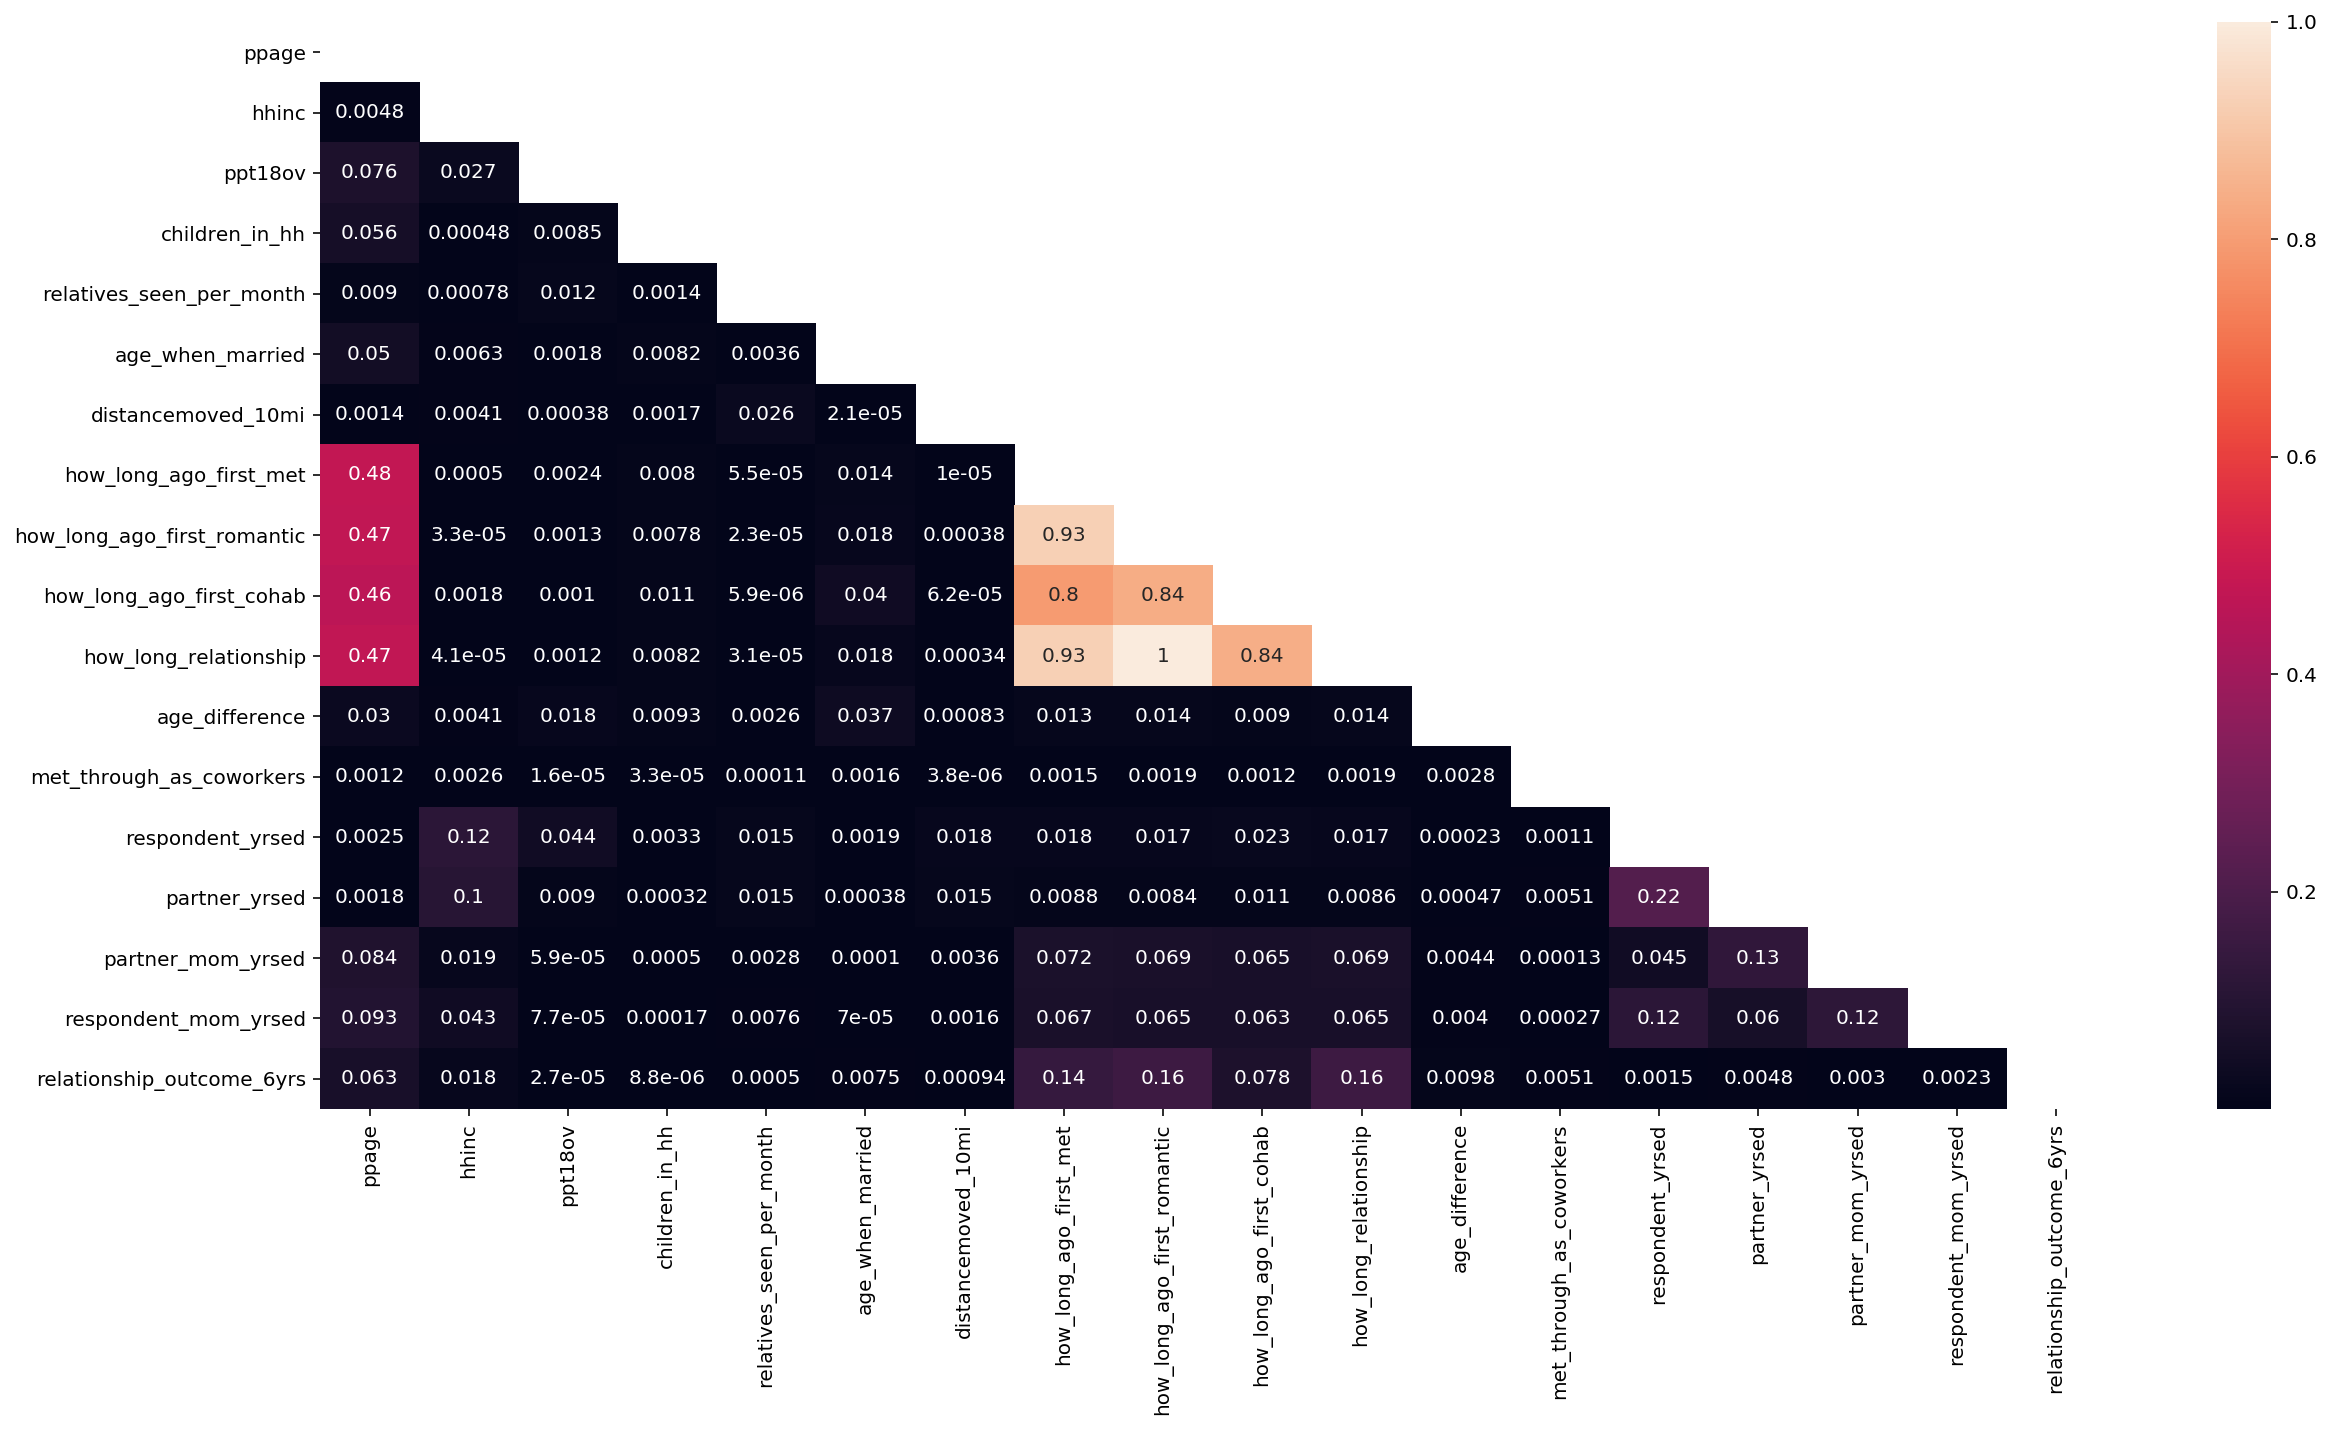

In [803]:
# See relationship for continuous features
plt.figure(figsize=(20,10))
couple_data_cont = couple_data.select_dtypes(include=['float32','float64','int64','int8'])
corr = couple_data_cont.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr**2, mask=mask,annot=True)

In [804]:
# p value for highly correlated variables
print(sp.stats.pearsonr(couple_data['how_long_ago_first_met'], couple_data['how_long_relationship']))
print(sp.stats.pearsonr(couple_data['how_long_ago_first_met'], couple_data['how_long_ago_first_cohab']))
print(sp.stats.pearsonr(couple_data['how_long_ago_first_met'], couple_data['how_long_ago_first_romantic']))
print(sp.stats.pearsonr(couple_data['how_long_relationship'], couple_data['how_long_ago_first_romantic']))
print(sp.stats.pearsonr(couple_data['how_long_ago_first_cohab'], couple_data['how_long_ago_first_romantic']))
print(sp.stats.pearsonr(couple_data['how_long_ago_first_cohab'], couple_data['how_long_relationship']))

(0.96397185210540226, 0.0)
(0.89266288215645995, 0.0)
(0.96413106707755047, 0.0)
(0.99964731247755167, 0.0)
(0.91633225123066497, 0.0)
(0.91681590535604551, 0.0)


In [805]:
# P values are below 0.05, correlation between variables are statistically insignificant
# Do not need to remove them

/Users/david.yan/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a314bb390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a58948198>]], dtype=object)

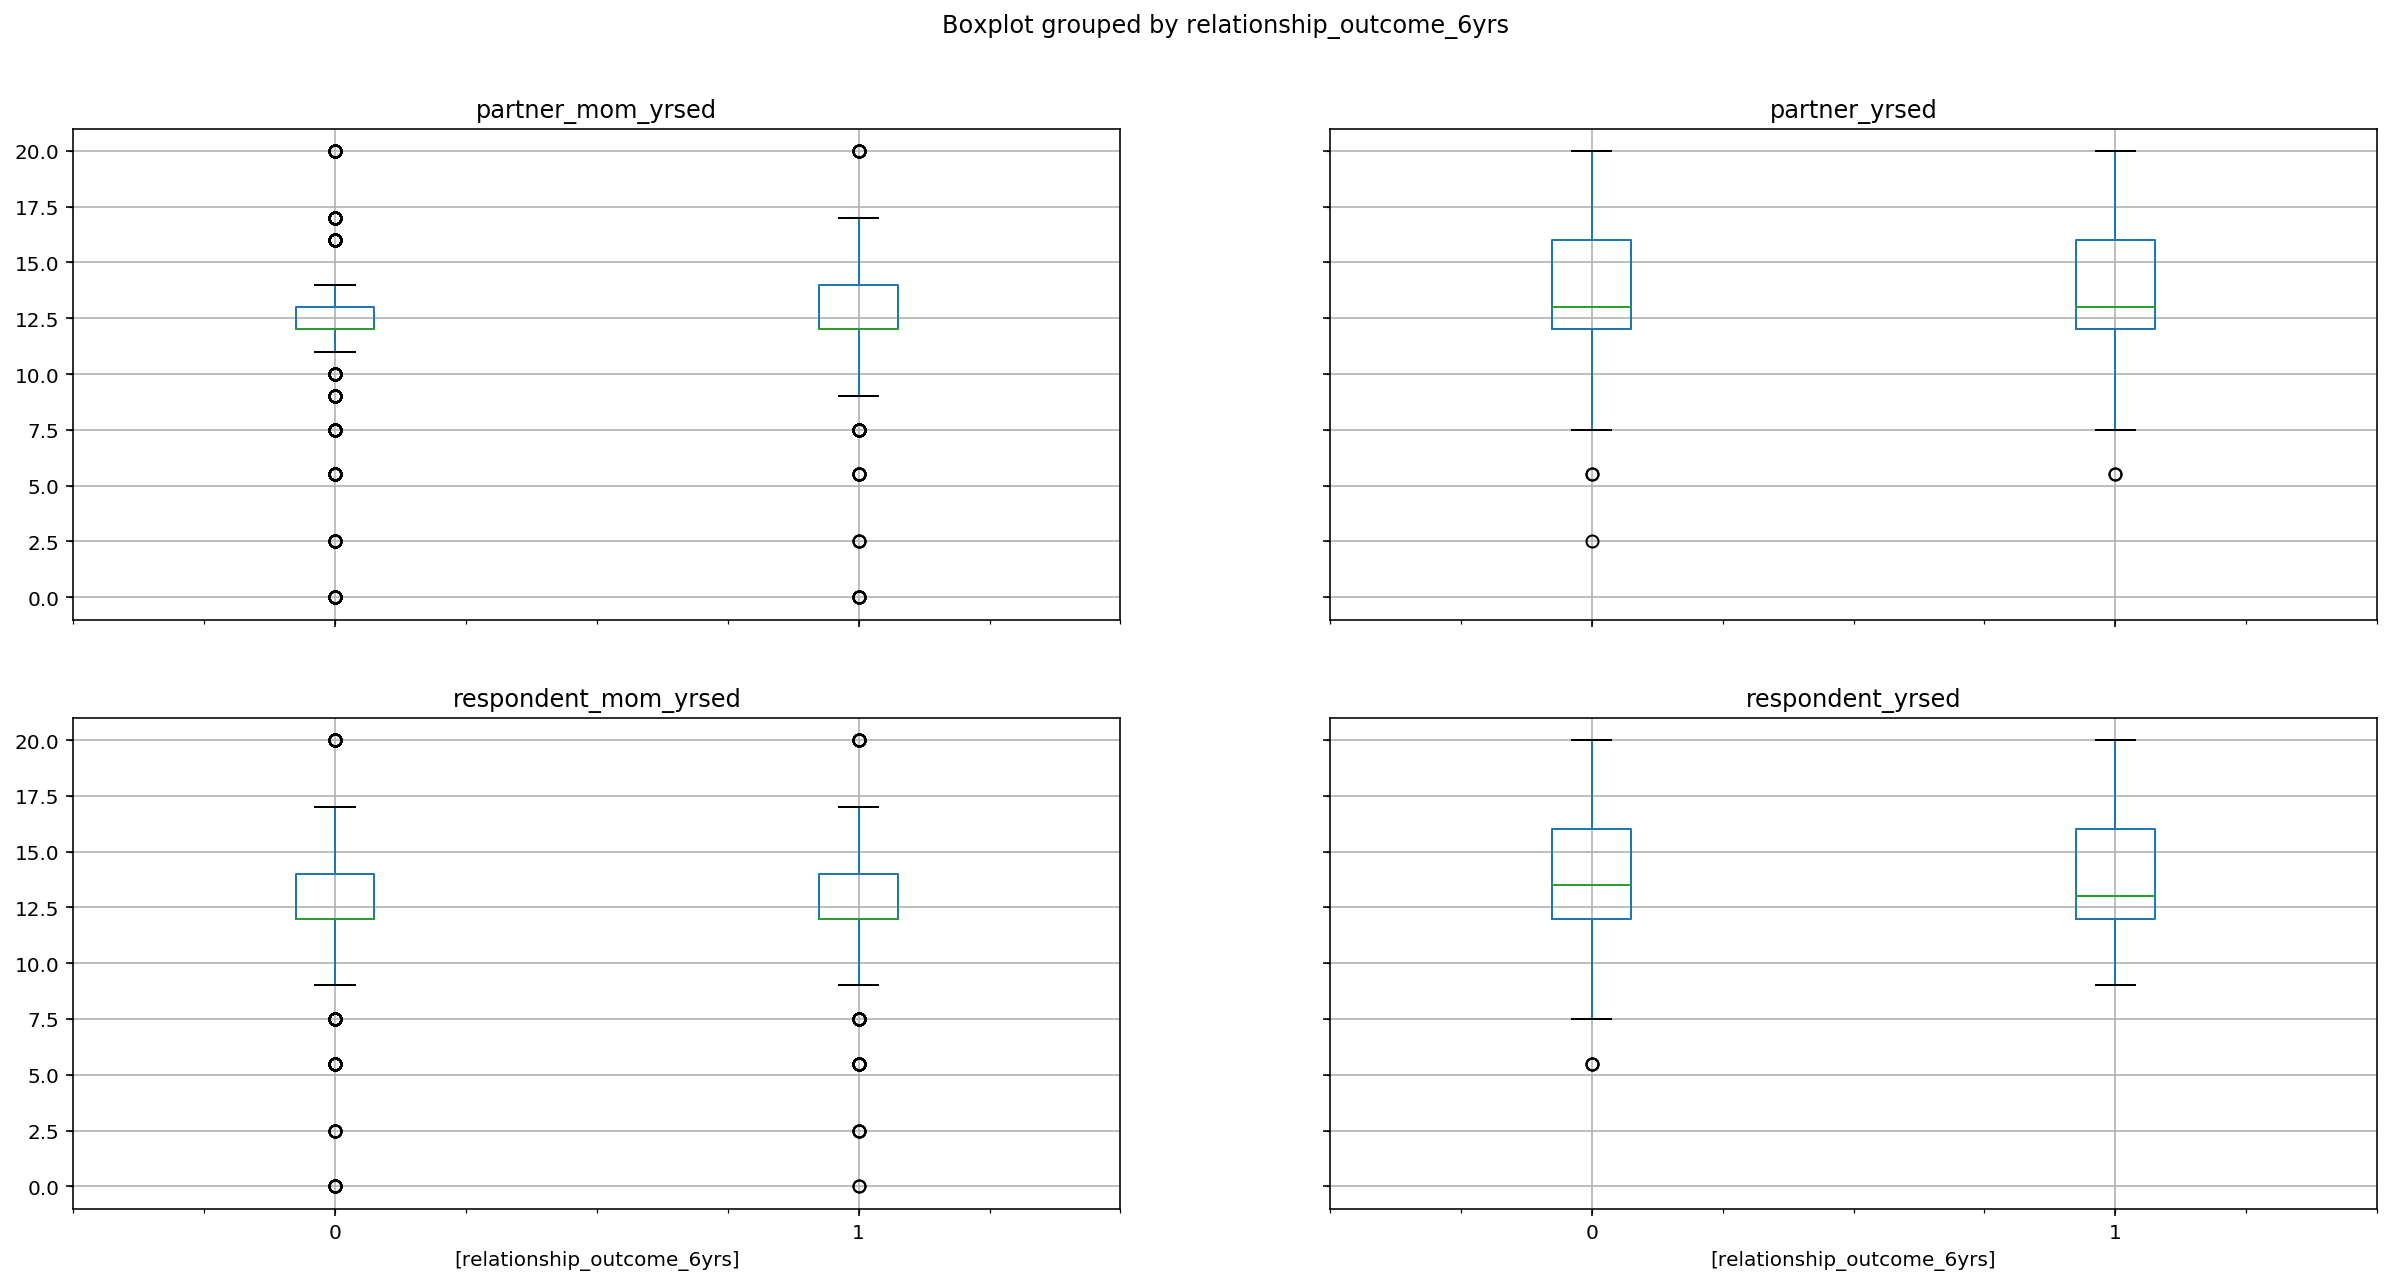

In [806]:
# What about years of education
cols = ['respondent_yrsed','partner_yrsed','partner_mom_yrsed','respondent_mom_yrsed','relationship_outcome_6yrs']
couple_data_cont[cols].boxplot(by='relationship_outcome_6yrs', figsize=(20,10))

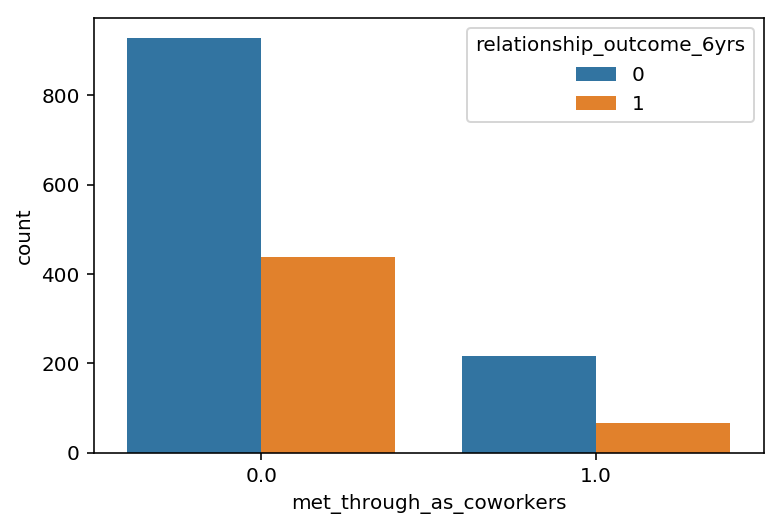

In [807]:
# Met through as co-workers and relationship outcome
sns.countplot(x='met_through_as_coworkers',hue='relationship_outcome_6yrs',data=couple_data_cont)

In [808]:
# Relationship seem to be due to imbalance data
# Resample Data for more accurate picture of relationships
# Convert categorical into dummies
import patsy
f = 'relationship_outcome_6yrs ~ ' + ' + '.join([col for col in couple_data.columns if col != 'relationship_outcome_6yrs' and col != 'relationship_quality'])
y, X = patsy.dmatrices(f, data=couple_data, return_type='dataframe')
y = y.values.ravel()

In [809]:
# Resample using SMOTE + Tomek
from imblearn.combine import SMOTETomek
smtomek = SMOTETomek(random_state=42)
X_st, y_st = smtomek.fit_sample(X, y)

In [810]:
X_st_df = pd.DataFrame(X_st, columns=[col for col in X.columns])
y_st_df = pd.DataFrame(y_st, columns=['relationship_outcome_6yrs'])
X_st_df.met_through_as_coworkers = X_st_df.met_through_as_coworkers.astype('int64')

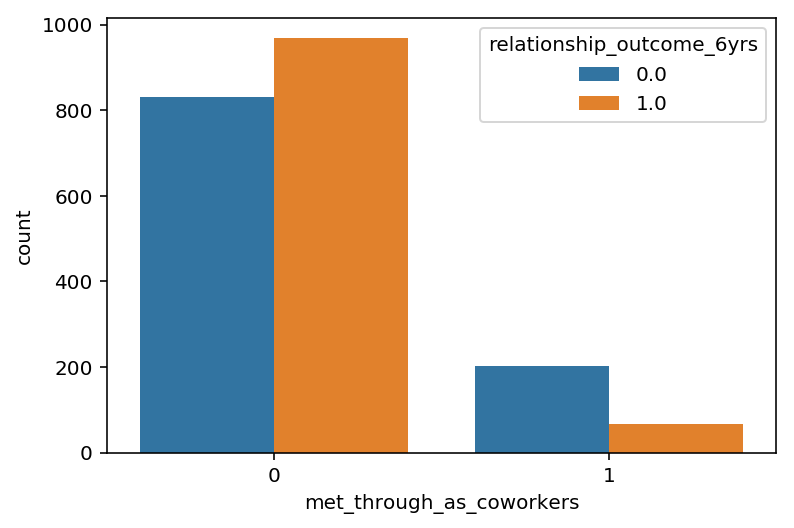

In [811]:
# Resample then plot again
sns.countplot(x=X_st_df['met_through_as_coworkers'], hue=y_st_df['relationship_outcome_6yrs'])

In [812]:
# Round age difference to whole numbers
X_st_df.age_difference = X_st_df.age_difference.astype('int64')

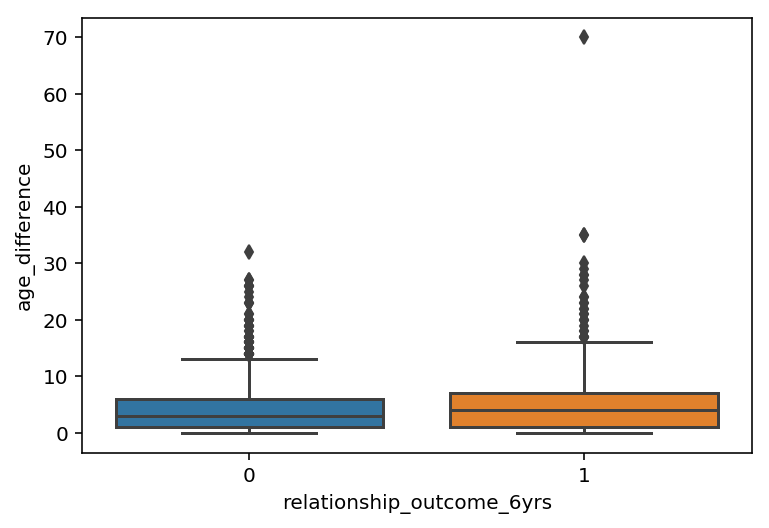

In [813]:
# Check whether age is able to classify relationship outcome
sns.boxplot(x="relationship_outcome_6yrs", y="age_difference", data=couple_data_cont)

In [814]:
# Impute Extreme Outlier as Median Age
median_age = X_st_df.age_difference.median()
X_st_df.age_difference.loc[124] = median_age

/Users/david.yan/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a58981b38>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a4a7057f0>]], dtype=object)

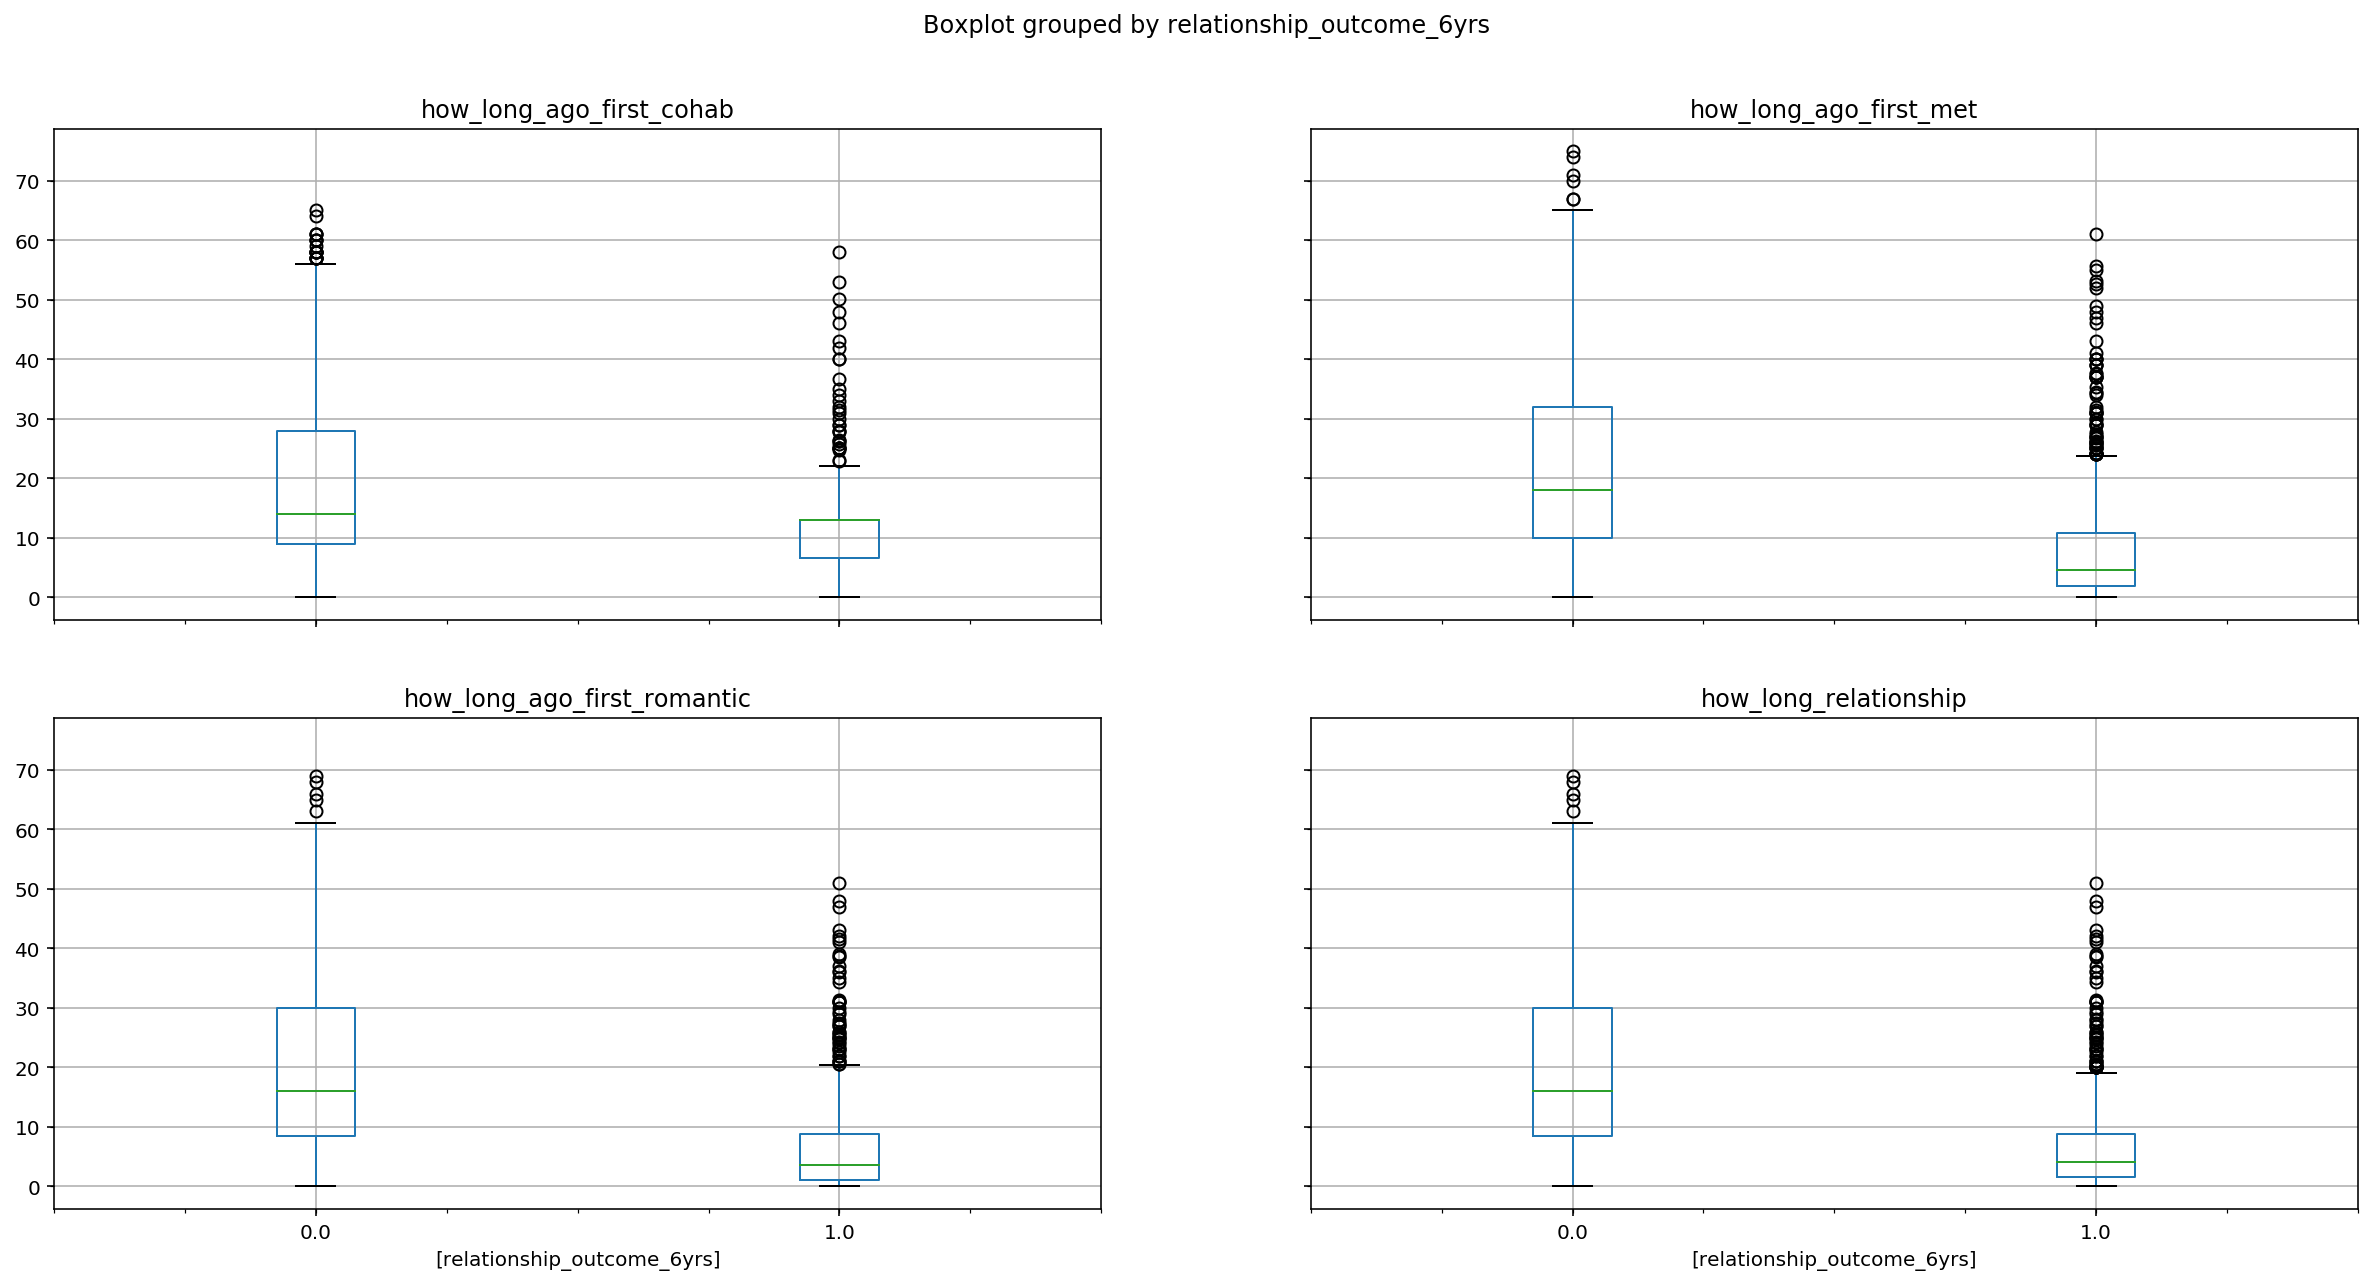

In [815]:
# How long ago first met, how long ago first romantic, how long ago first cohab, how long relationship
how_long_cols = ['how_long_ago_first_met','how_long_ago_first_romantic',
                 'how_long_ago_first_cohab','how_long_relationship']
st_df = pd.concat([X_st_df[how_long_cols],y_st_df], axis=1)
st_df.boxplot(by='relationship_outcome_6yrs', figsize=(20,10))

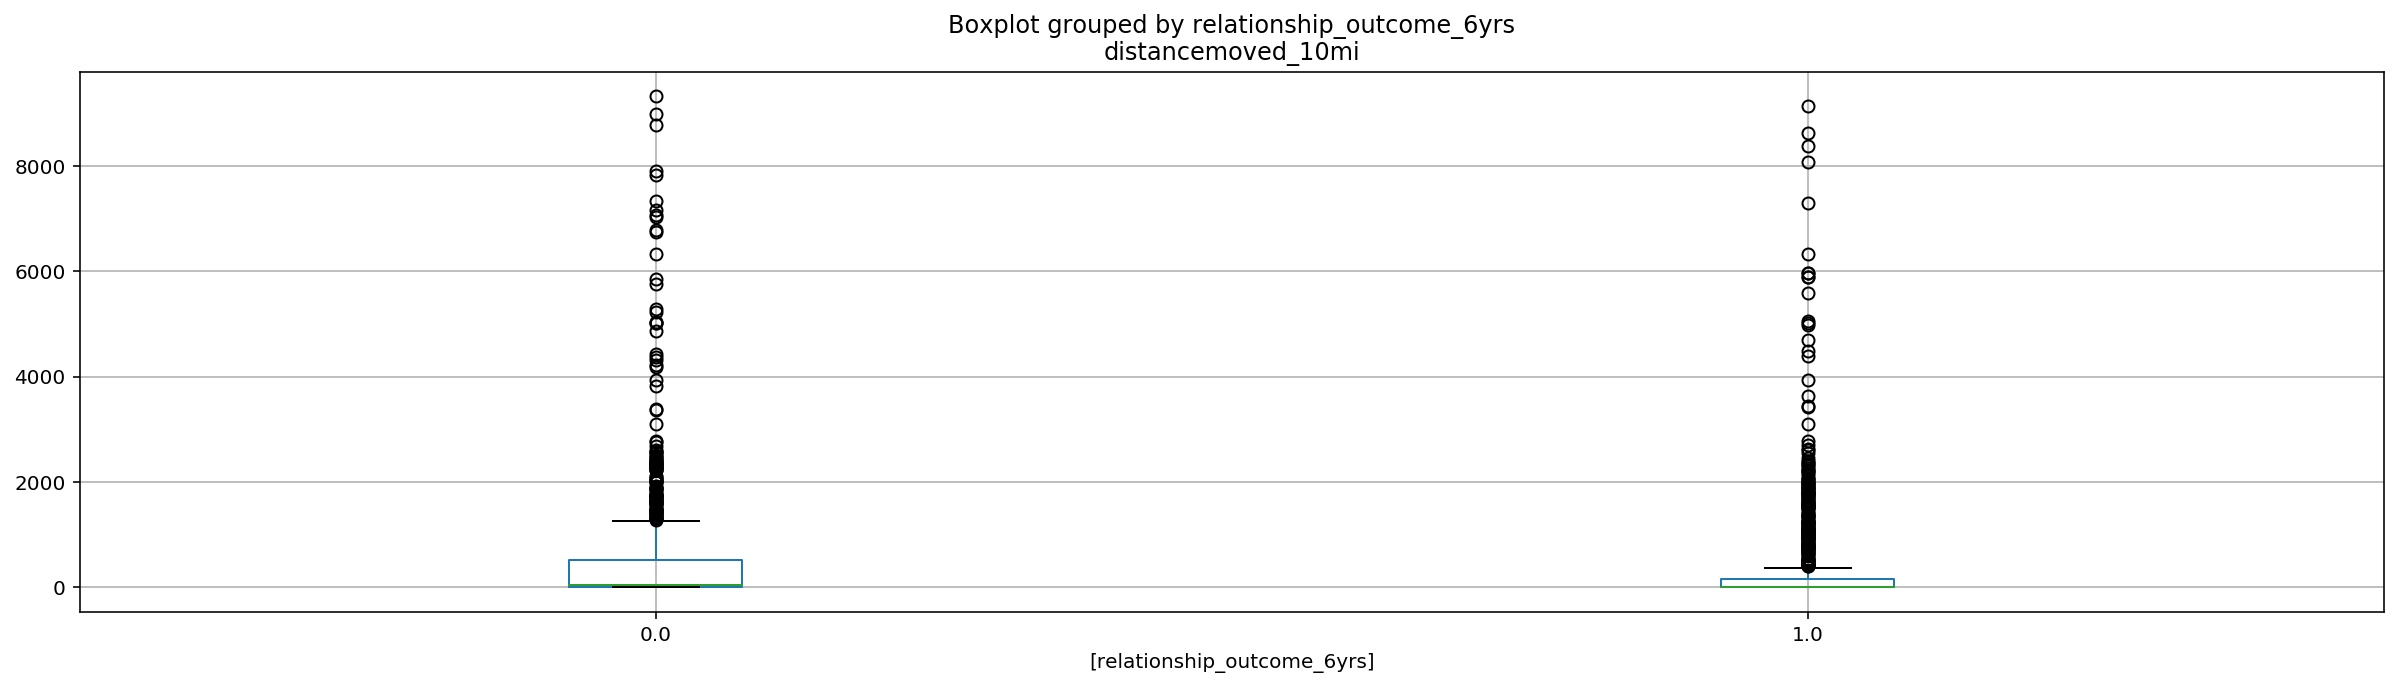

In [816]:
# Distance in Miles between resp home town and current home, to nearest 10 mi 
temp_cols = ['distancemoved_10mi']
st_df = pd.concat([X_st_df[temp_cols],y_st_df], axis=1)
st_df.boxplot(by='relationship_outcome_6yrs', figsize=(20,5))

In [817]:
def gen_ratio_odd_items_0(st_dict):
    
    breakup_ratio = []
    for i,(k,v) in enumerate(st_dict.items()):

        if i > 0 and i % 2 != 0:
            minus = int(np.ceil(i/2))
            count = st_dict[(i-minus,1)] + st_dict[(i-minus,0)]
            ratio = st_dict[(i-minus,1)] / float(count)
            breakup_ratio.append(ratio)

        else:
            if i == len(st_dict.keys())-1:
                try:
                    minus = int(np.floor(len(st_dict.keys())/2))
                    ratio = st_dict[(i-minus,0)] / st_dict[(i-minus,0)]
                    breakup_ratio.append(0)
                    
                except KeyError:
                    minus = int(np.floor(len(st_dict.keys())/2))
                    ratio = st_dict[(i-minus,1)] / st_dict[(i-minus,1)]
                    breakup_ratio.append(1)
                    
    return breakup_ratio

In [818]:
def gen_ratio_odd_items_1(st_dict):
    
    breakup_ratio = []
    for i,(k,v) in enumerate(st_dict.items()):

        if i > 0 and i % 2 != 0:
            minus = int(np.ceil(i/2))
            count = st_dict[(i-minus+1,1)] + st_dict[(i-minus+1,0)]
            ratio = st_dict[(i-minus+1,1)] / float(count)
            breakup_ratio.append(ratio)

        else:
            if i == len(st_dict.keys())-1:
                try:
                    minus = int(np.floor(len(st_dict.keys())/2))
                    ratio = st_dict[(i-minus+1,0)] / st_dict[(i-minus+1,0)]
                    breakup_ratio.append(0)
                    
                except KeyError:
                    minus = int(np.floor(len(st_dict.keys())/2))
                    ratio = st_dict[(i-minus+1,1)] / st_dict[(i-minus+1,1)]
                    breakup_ratio.append(1)
                    
    return breakup_ratio

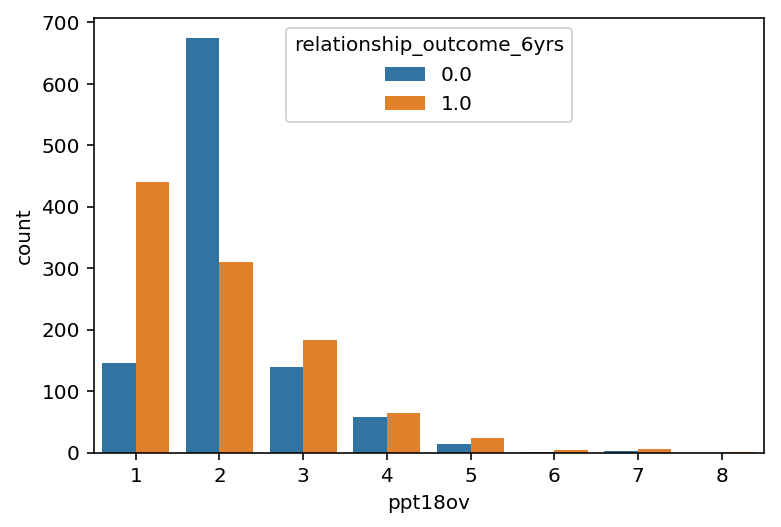

In [819]:
# number of adults age 18+ in HH
X_st_df.ppt18ov = X_st_df.ppt18ov.astype('int64')
sns.countplot(x=X_st_df['ppt18ov'],hue=y_st_df['relationship_outcome_6yrs'])

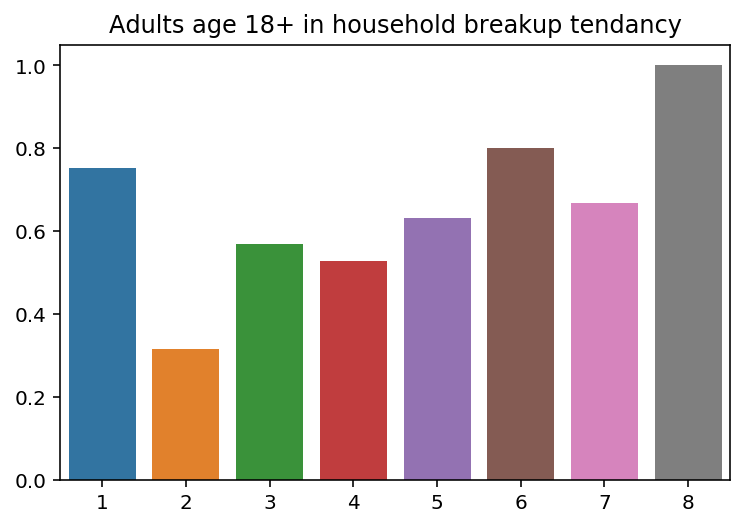

In [820]:
# Plot ppt18ov breakup ratio
ppt18ov_unique = X_st_df.ppt18ov.unique().tolist()
ppt18ov_unique = np.sort(ppt18ov_unique)
st_df = pd.concat([X_st_df['ppt18ov'],y_st_df['relationship_outcome_6yrs']], axis=1)
st_dict = st_df.groupby(['ppt18ov'])['relationship_outcome_6yrs'].value_counts().to_dict()
breakup_ratio = gen_ratio_odd_items_1(st_dict)
plt.title('Adults age 18+ in household breakup tendancy')
sns.barplot(x=ppt18ov_unique, y=breakup_ratio)
plt.legend()

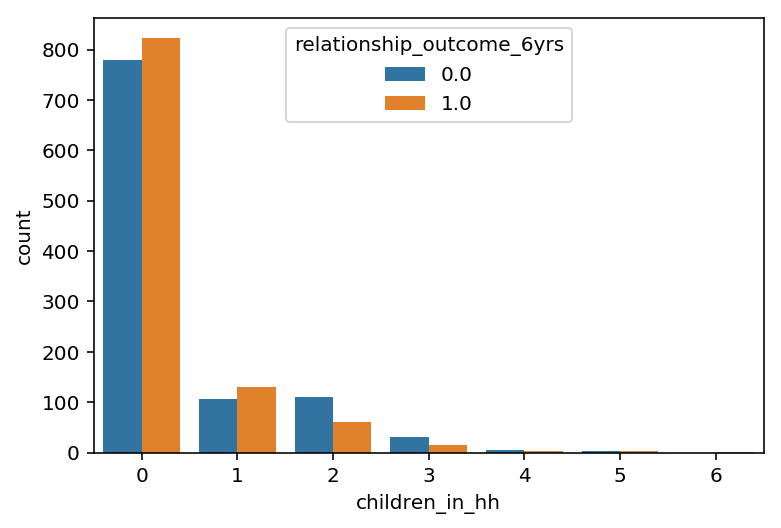

In [821]:
# Plot children in household vs relationship outcome
X_st_df.children_in_hh = X_st_df.children_in_hh.astype('int64')
sns.countplot(x=X_st_df['children_in_hh'], hue=y_st_df['relationship_outcome_6yrs'])

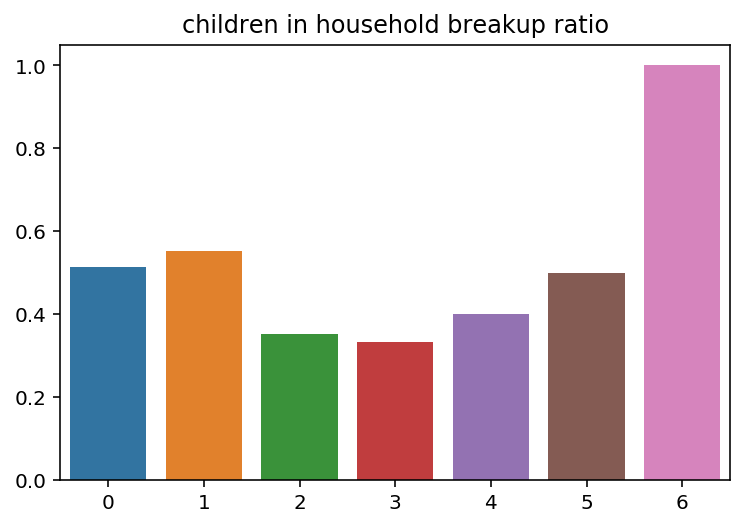

In [822]:
# Plot children in household breakup ratio
children_hh_unique = X_st_df.children_in_hh.unique().tolist()
children_hh_unique = np.sort(children_hh_unique)
st_df = pd.concat([X_st_df['children_in_hh'],y_st_df['relationship_outcome_6yrs']], axis=1)
st_dict = st_df.groupby(['children_in_hh'])['relationship_outcome_6yrs'].value_counts().to_dict()
breakup_ratio = gen_ratio_odd_items(st_dict)
plt.title('children in household breakup ratio')
sns.barplot(x=children_hh_unique, y=breakup_ratio)
plt.legend()

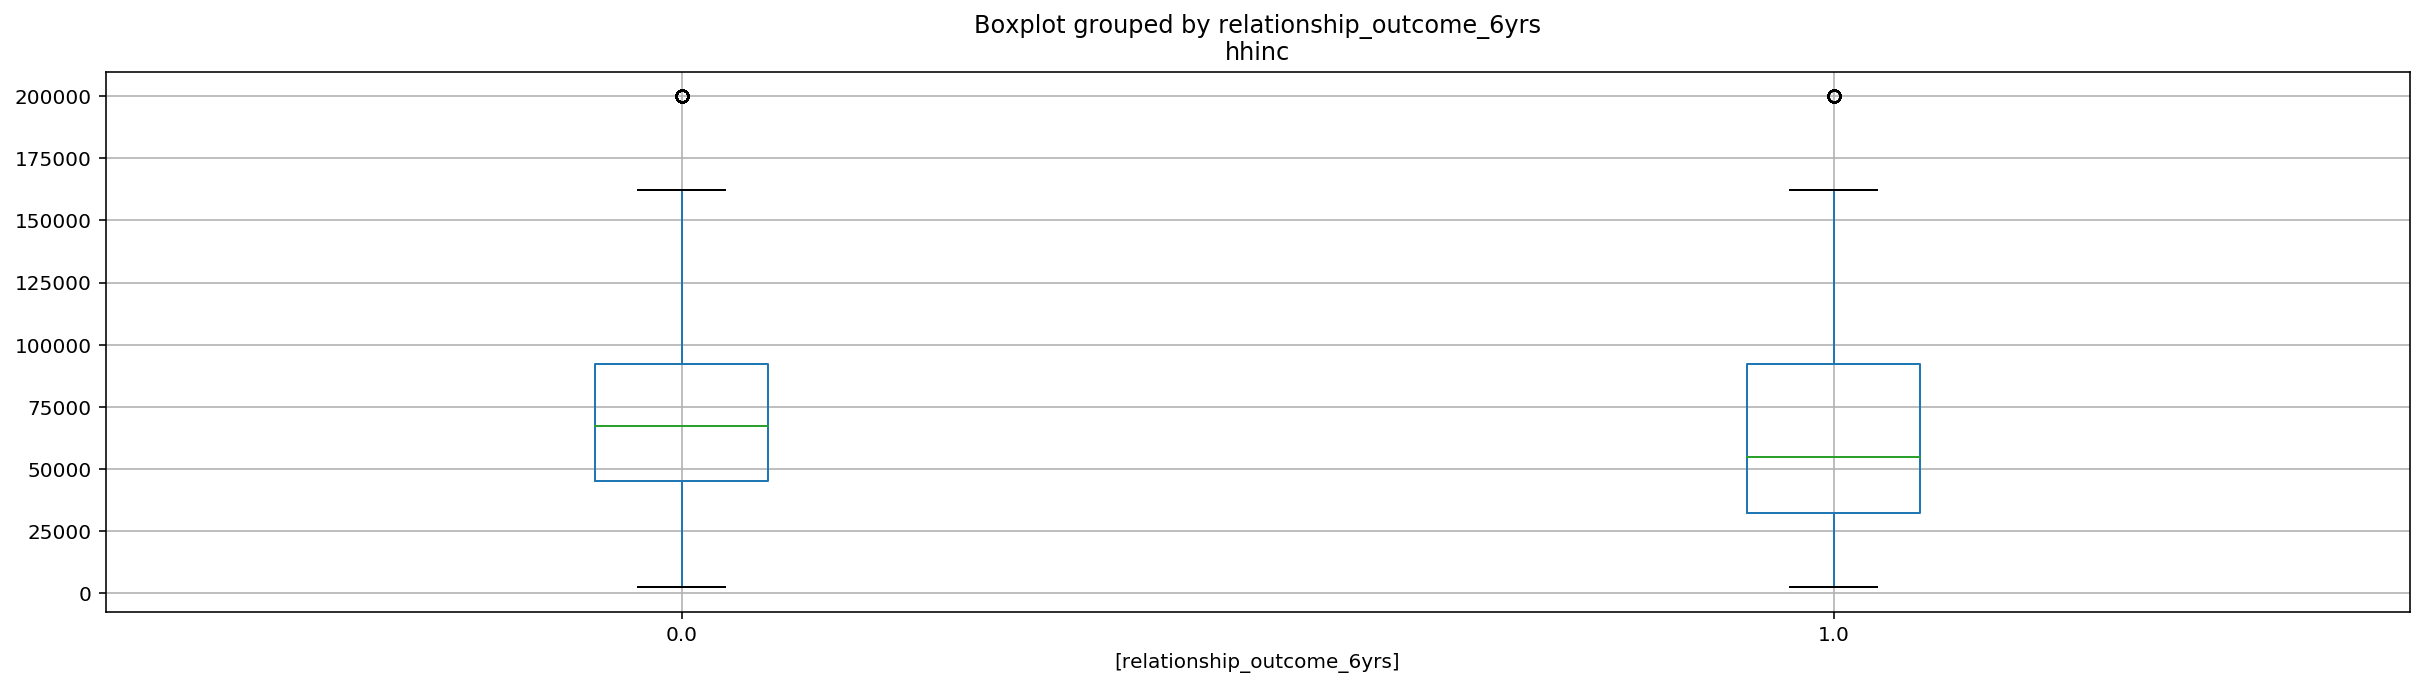

In [823]:
# hhincome divide into brackets
temp_cols = ['hhinc']
st_df = pd.concat([X_st_df[temp_cols],y_st_df], axis=1)
st_df.boxplot(by='relationship_outcome_6yrs', figsize=(20,5))

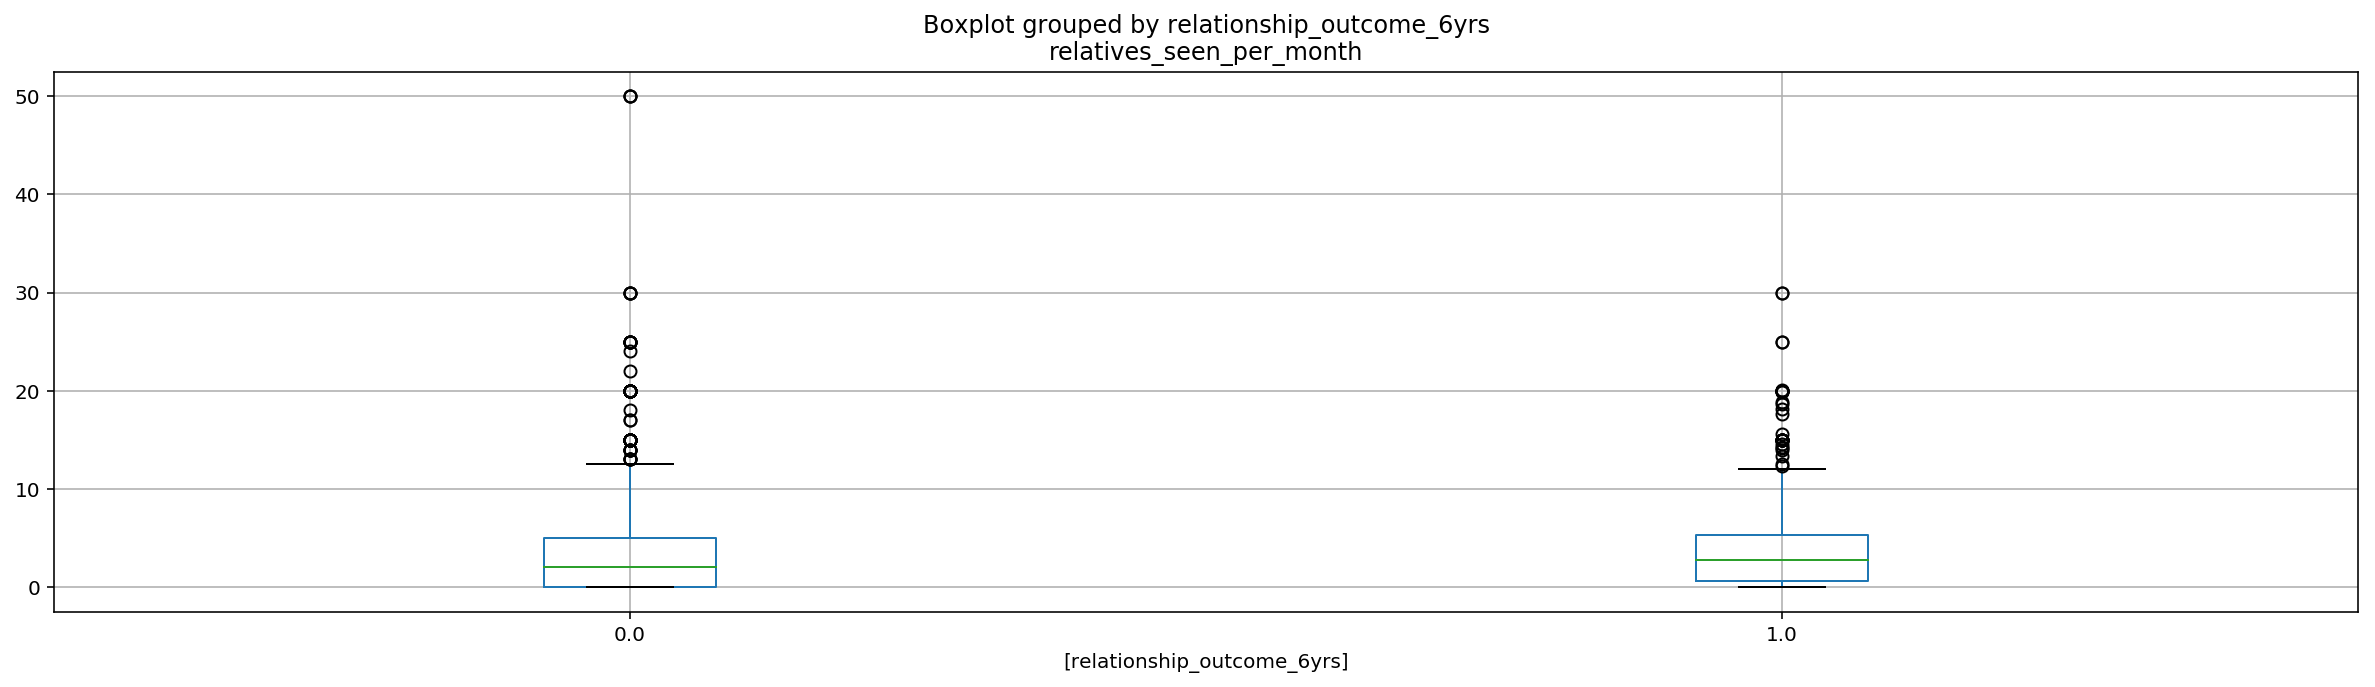

In [824]:
# relatives seen per month
temp_cols = ['relatives_seen_per_month']
st_df = pd.concat([X_st_df[temp_cols],y_st_df], axis=1)
st_df.boxplot(by='relationship_outcome_6yrs', figsize=(20,5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a535efcf8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a597bb630>], dtype=object)

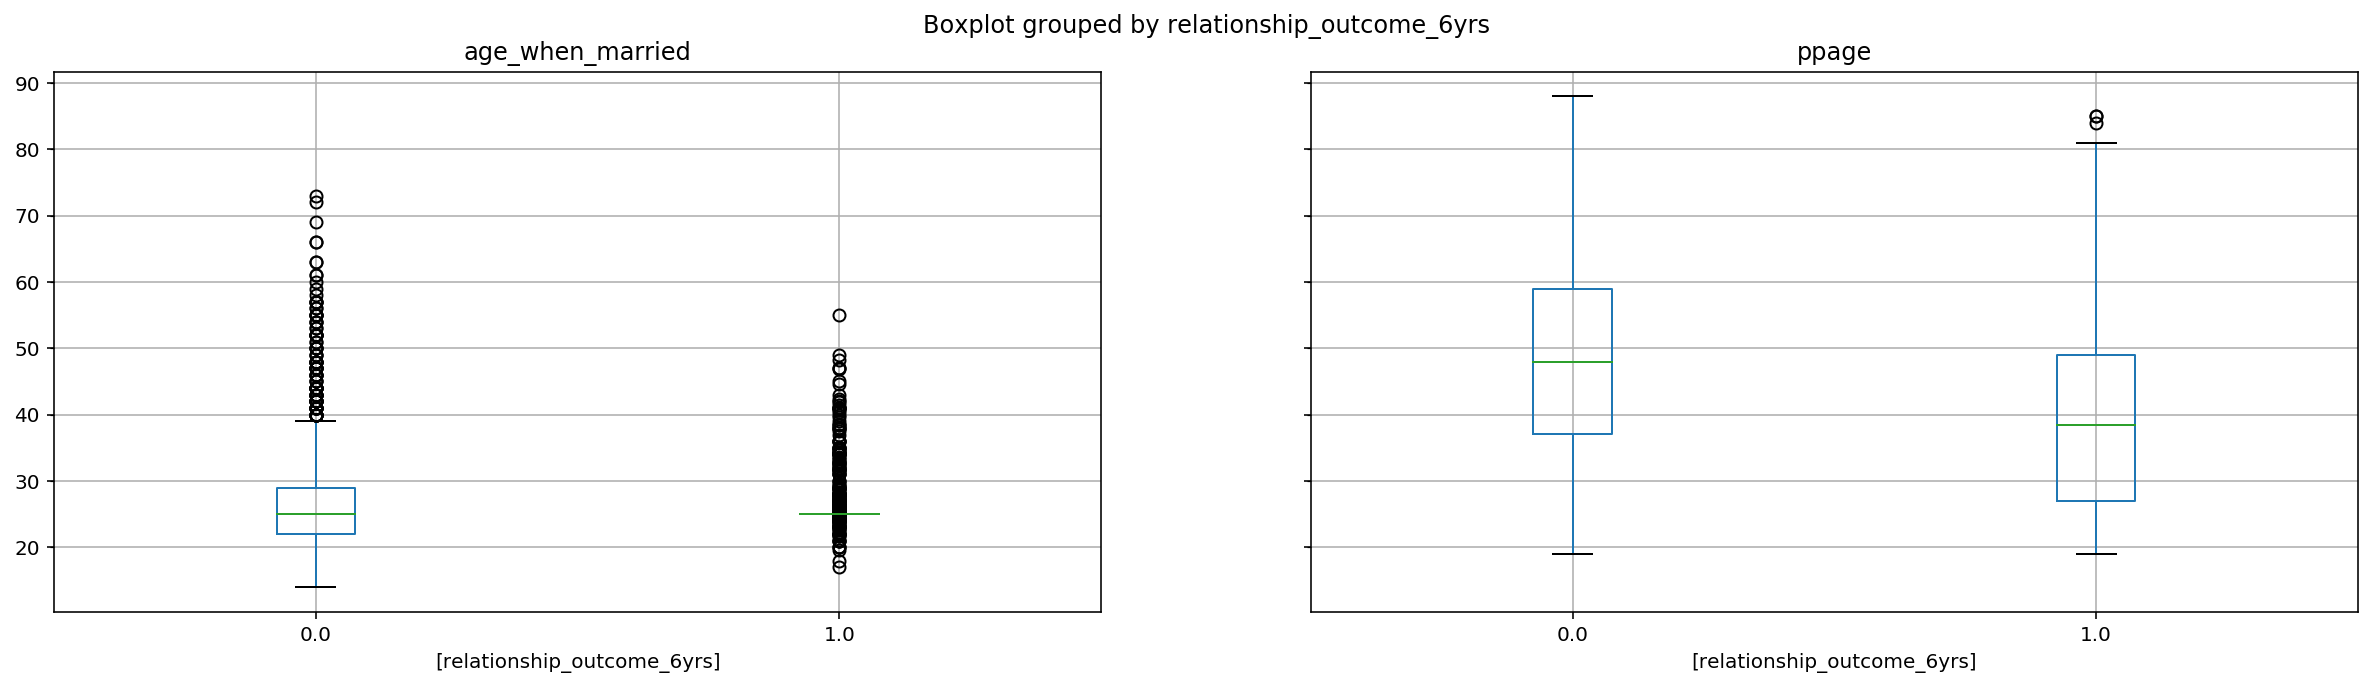

In [825]:
# ppage, hhinc, age when married, relatives seen per month, children in household
temp_cols = ['age_when_married','ppage']
st_df = pd.concat([X_st_df[temp_cols],y_st_df], axis=1)
st_df.boxplot(by='relationship_outcome_6yrs', figsize=(20,5))

# Modelling

In [826]:
# Baseline Accuracy
1 - y.mean()

0.69459623557984207

In [827]:
# Logistic Regression
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [828]:
# Scale the original features
Xs = StandardScaler().fit_transform(X)

In [829]:
# Scale the resampled features
Xs_st = StandardScaler().fit_transform(X_st_df)
y_st = y_st_df.values.ravel()

#### Plain Vanilla Logistic Regression

In [830]:
# Plain vanilla logistic regression
lr = LogisticRegression()
predicted = cross_val_predict(lr, Xs, y, cv=10)
print(metrics.classification_report(y, predicted, labels=[1,0], target_names=['break up','still together']))

Accuracy: 0.799635701275
-----------------------------------------------
                precision    recall  f1-score   support

      break up       0.69      0.62      0.66       503
still together       0.84      0.88      0.86      1144

   avg / total       0.80      0.80      0.80      1647



#### Perform Plain Logistic Regression again

In [831]:
# Plain vanilla logistic regression with resample 
predicted = cross_val_predict(lr, Xs_st, y_st, cv=10)
print(metrics.classification_report(y_st, predicted, labels=[1,0], target_names=['break up','still together']))

Accuracy: 0.838164251208
-----------------------------------------------
                precision    recall  f1-score   support

      break up       0.83      0.85      0.84      1035
still together       0.85      0.83      0.84      1035

   avg / total       0.84      0.84      0.84      2070



#### Ridge Logistic Regression

In [832]:
# Ridge logistic regression
lr_ridge = LogisticRegressionCV(penalty='l2', Cs=200, cv=10)
lr_ridge.fit(Xs_st, y_st)
ridge_predicted = lr_ridge.predict(Xs_st)
print(metrics.classification_report(y_st, ridge_predicted, labels=[1,0], target_names=['break up','still together']))

Ridge Accuracy: 0.863285024155
-----------------------------------------------
                precision    recall  f1-score   support

      break up       0.86      0.87      0.86      1035
still together       0.87      0.86      0.86      1035

   avg / total       0.86      0.86      0.86      2070



#### Lasso Logistic Regression

In [833]:
# Lasso Logistic Regression
lr_lasso = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=100, cv=10)
lr_lasso.fit(Xs_st, y_st)
lasso_predicted = lr_lasso.predict(Xs_st)
print(metrics.classification_report(y_st, lasso_predicted, labels=[1,0], target_names=['break up','still together']))

Ridge Accuracy: 0.864251207729
-----------------------------------------------
                precision    recall  f1-score   support

      break up       0.86      0.87      0.86      1035
still together       0.87      0.86      0.86      1035

   avg / total       0.86      0.86      0.86      2070



In [890]:
# Gridsearch for Ridge and Lasso Logistic Regression, optimize C

parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}

print ("GRID SEARCH:")
lr_grid_search = GridSearchCV(LogisticRegression(), parameters, cv=10, verbose=0)
lr_grid_search.fit(Xs_st, y_st)
print ("Best parameters set:")
lr_best_parameters = lr_grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print ("\t%s: %r" % (param_name, lr_best_parameters[param_name]))
print ("-----------------------------------------")
print ("-----------------------------------------")
print ("CROSS VALIDATION:")
clf = LogisticRegression(**lr_best_parameters)
lr_gs_predicted = cross_val_predict(clf, Xs_st, y_st,
    cv=10)
print(metrics.classification_report(y_st, lr_gs_predicted, labels=[1,0], target_names=['break up','still together']))

GRID SEARCH:
Best parameters set:
	C: 0.13848863713938717
	penalty: 'l1'
	solver: 'liblinear'
-----------------------------------------
-----------------------------------------
CROSS VALIDATION:
                precision    recall  f1-score   support

      break up       0.85      0.85      0.85      1035
still together       0.85      0.85      0.85      1035

   avg / total       0.85      0.85      0.85      2070



In [894]:
# Gridsearch SGDclassifier with log loss and optimal learning rate

sgd_parameters = {
    'learning_rate': ['optimal'],
    'loss':['log'],
    'penalty': ['elasticnet'],
    'alpha': np.logspace(-10,5,100),
    'l1_ratio': np.logspace(-1,0,20)
}

print ("GRID SEARCH:")
sgd_grid_search = GridSearchCV(SGDClassifier(tol=0.0001), sgd_parameters, cv=10, verbose=0)
sgd_grid_search.fit(Xs_st, y_st)
print ("Best parameters set:")
sgd_best_parameters = sgd_grid_search.best_estimator_.get_params()
for param_name in sorted(sgd_parameters.keys()):
    print ("\t%s: %r" % (param_name, sgd_best_parameters[param_name]))
print ("-----------------------------------------")
print ("-----------------------------------------")
print ("CROSS VALIDATION:")
clf = SGDClassifier(**sgd_best_parameters)
sgd_predicted = cross_val_predict(clf, Xs_st, y_st,
    cv=10)
print(metrics.classification_report(y_st, sgd_predicted, labels=[1,0], target_names=['break up','still together']))

	alpha: 0.0075646332755462909
	l1_ratio: 0.26366508987303583
	learning_rate: 'optimal'
	loss: 'log'
	penalty: 'elasticnet'
-----------------------------------------
-----------------------------------------
CROSS VALIDATION:
                precision    recall  f1-score   support

      break up       0.85      0.85      0.85      1035
still together       0.85      0.85      0.85      1035

   avg / total       0.85      0.85      0.85      2070



In [836]:
# clf = xgb.XGBClassifier(missing=np.nan, max_depth=7, 
#                         n_estimators=300, learning_rate=0.05, 
#                         subsample=1, colsample_bytree=0.9, seed=2100, objective= 'binary:logistic')

# Questions
* how does ENN and Tomek work in under sampling?
* Does LogisticRegressionCV perform cross validation like cross_val_predict/cross_val_score?
* How do i filter out highly correlated variables?

In [837]:
# AdaBoost, XGboostClassifier, 